In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [33]:
# Utilities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Get best models (detrmined by analisys)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor

# Metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

In [3]:
# Load data
df = pd.read_csv('../data/ghi.csv')
y = df['GHI']
X = df.drop('GHI', axis=1)

In [4]:
# Simple comparison
models = {
    'GBRegressor': GradientBoostingRegressor(),
    'RFRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'XGBFRegressor': XGBRFRegressor()
}

socres = []
for name, model in models.items():
    score = cross_validate(model, X, y, 
                           scoring=('r2', 'neg_mean_squared_error'),
                           cv=5, return_train_score=True,
                           return_estimator=True)

    socres.append(score)

In [36]:
# Auxiliar function for visualization results

# Visualization plot performance
def plot_performance(y_pred, y_test, name, score):
    """Return the dispersion performance plot"""

    plt.plot(y_test, y_test, 'k--', lw=0.9, c='darkorange')
    plt.scatter(y_test, y_pred, c='skyblue', 
                label='Predicted (R2:{:0.3f})'.format(score))
    plt.title(f'Performance plot: {name}', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.xlabel('True data')
    plt.ylabel('Predicted data')
    plt.show()

# Get scores
def get_scores(score):
    """Return the escores for test and train"""

    train_info = (score['train_r2'].mean(),
                  np.abs(score['train_neg_mean_squared_error'].mean()))
    test_info = (score['test_r2'].mean(),
                  np.abs(score['test_neg_mean_squared_error'].mean()))
    fit_time = score['fit_time'].mean()

    return (train_info, test_info, fit_time)

# Predict target for performance plot
def predict_target(score, X):
    """Return the y prediction"""
    predictions = [] 
    for estimator in score['estimator']:
        y_pred = estimator.predict(X)
        predictions.append(y_pred)

    predictions = np.asarray(predictions)

    return predictions.mean(axis=0)

# Report permormance
def report(score, X, y, name, i):
    """Create a mini report for each model"""

    # Scores and fit time
    info = get_scores(score)

    # Get the prediction for each model
    y_pred = predict_target(score, X)
    r2 = r2_score(y, y_pred)

    # Report format
    print('='*60)
    print(f'------ {name} ------\n')
    print('Train:')
    print('R2: {:0.3f}\nMSE: {:0.3f}'.format(info[0][0], info[0][1]))
    print('-'*60)
    print('Test:')
    print('R2: {:0.3f}\nMSE: {:0.3f}'.format(info[1][0], info[1][1]))
    print('-'*60)
    print('General:')
    print('Fit time: {:0.3f} | Dif_train_test: {:0.3f}'.format(
        info[2], info[0][0]-info[1][0]))
    print('R2 mean: {:0.4f}'.format(r2))

    # Plot performance
    plt.rcParams['figure.figsize'] = [8,8]
    plot_performance(y_pred, y, name, r2)

------ Gradient Boosting Regressor ------

Train:
R2: 0.919
MSE: 8574.144
------------------------------------------------------------
Test:
R2: 0.915
MSE: 8973.263
------------------------------------------------------------
General:
Fit time: 82.716 | Dif_train_test: 0.004
R2 mean: 0.9256


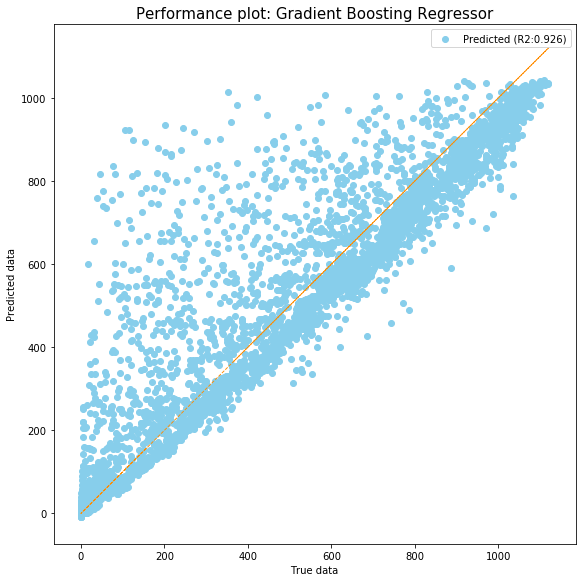

------ Random Forest Regressor ------

Train:
R2: 0.990
MSE: 1061.845
------------------------------------------------------------
Test:
R2: 0.913
MSE: 9136.942
------------------------------------------------------------
General:
Fit time: 212.162 | Dif_train_test: 0.076
R2 mean: 0.9832


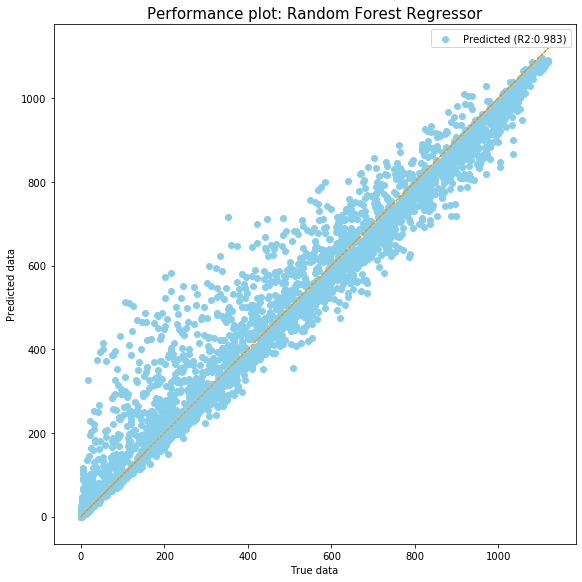

------ Xtreme Boosting Regressor ------

Train:
R2: 0.935
MSE: 6928.362
------------------------------------------------------------
Test:
R2: 0.913
MSE: 9142.321
------------------------------------------------------------
General:
Fit time: 19.033 | Dif_train_test: 0.021
R2 mean: 0.9351


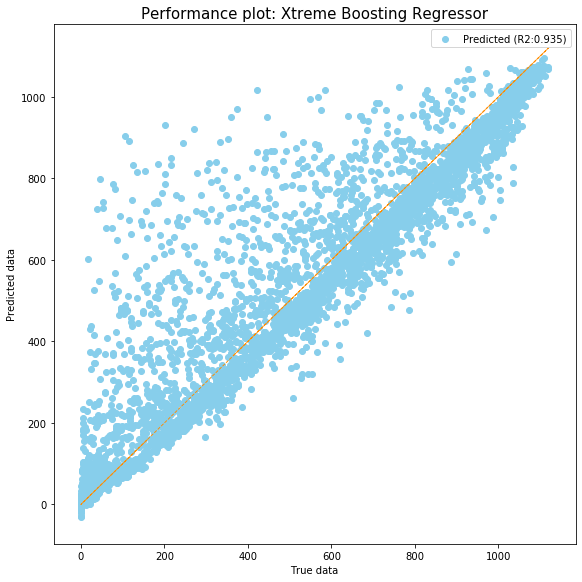

In [57]:
# Print names
names = [
    'Gradient Boosting Regressor',
    'Random Forest Regressor',
    'Xtreme Boosting Regressor'
]

# Alias
scores = socres

for i in range(len(names)):
    report(scores[i], X[8760*9:8760*10], y[8760*9:8760*10], names[i], i)

## Conclusion
For separated, the best model is Gradient Boosting Regressor
But with stacking regressor by mean, the best is Random Forest Regressor

In [41]:
# Save model
import joblib

path = './models/rfr_stacking_by_mean.pkl'
model = scores[1]['estimator']
joblib.dump(model, path);

In [42]:
# Test model
rfr_model = joblib.load('./models/rfr_stacking_by_mean.pkl')
rfr_model

(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_star